In [1]:
%load_ext autoreload
%autoreload 2
from nvidia.dali.plugin.pytorch import DALIGenericIterator
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import numpy as np
import torch
from torch import optim, nn
from pytorch_metric_learning import losses
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from data import (
    get_urls_indexes,
    pipeline,
    benchmark_pipeline,
    get_max_frames,
    num_frames_to_attention_mask,
    EMOTIONS,
)
from utils import log, get_timestamp

In [2]:
model_device = torch.device("cuda:1")
dali_device = model_device.index

In [156]:
urls, indexes = get_urls_indexes("../hf/export/MSP_PODCAST/", random_shuffle=True)
# urls, indexes = get_urls_indexes("../hf/export/IEMOCAP_audio/", random_shuffle=True)
max_duration = 2.5
hop_length = 160
num_mel = 80
batch_size = 256
max_frames = get_max_frames(max_duration=max_duration, hop_length=hop_length)
train_dl = DALIGenericIterator(
    pipelines=[
        pipeline(
            # urls=urls["Session1"]
            # + urls["Session2"]
            # + urls["Session3"]
            # + urls["Session4"],
            # index_paths=indexes["Session1"]
            # + indexes["Session2"]
            # + indexes["Session3"]
            # + indexes["Session4"],
            urls=urls["train"],
            index_paths=indexes["train"],
            random_shuffle=True,
            peak_normalize=True,
            preemphasis=True,
            max_duration=max_duration,
            hop_length=hop_length,
            num_mel=num_mel,
            augmentations=["spec_aug"],
            ref=True,
            ref_augmentations=["spec_aug"],
            batch_size=batch_size,
            num_threads=16,
            device_id=dali_device,
        )
    ],
    output_map=["mel", "mel_ref", "num_frames", "emodim", "emo"],
    reader_name="webdataset",
    auto_reset=False,
)

In [160]:
sample_batch = train_dl._first_batch[0]

In [161]:
i = 0

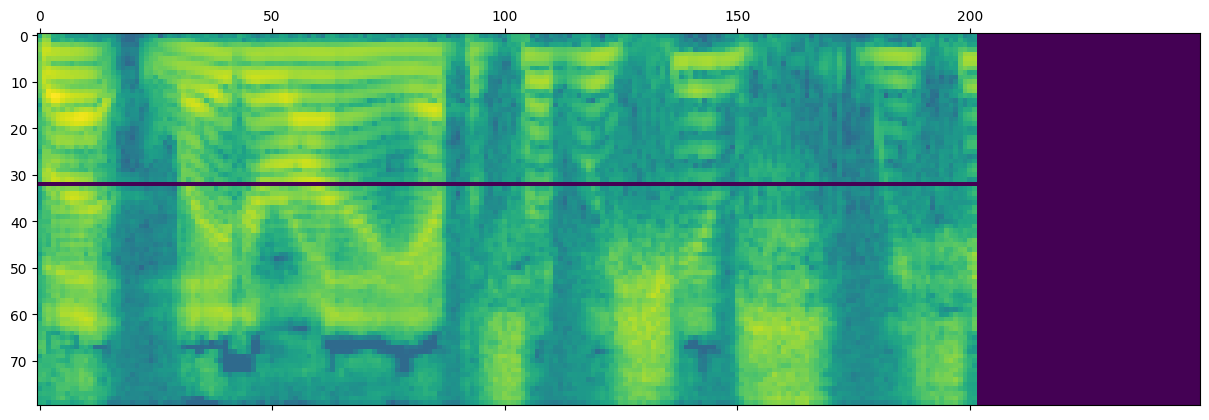

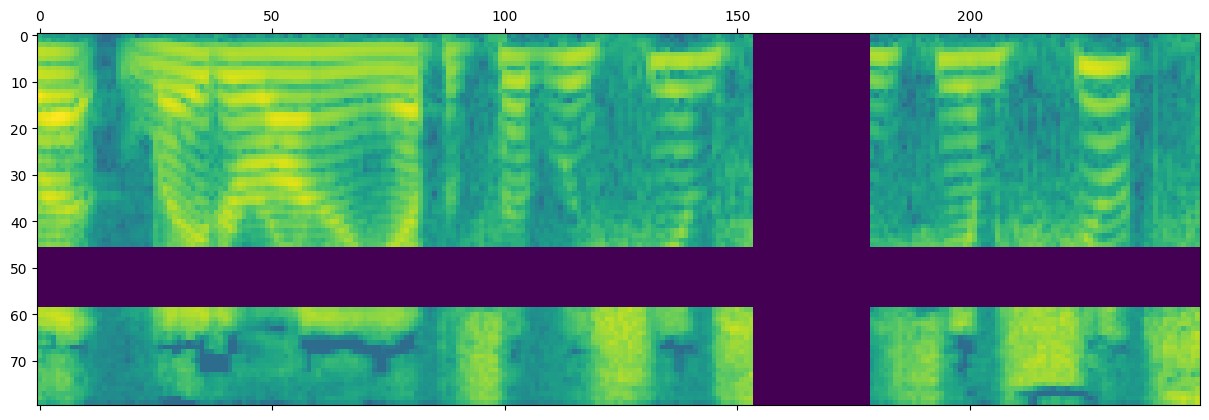

In [166]:
plt.matshow(sample_batch["mel"].cpu()[i])
_ = plt.matshow(sample_batch["mel_ref"].cpu()[i])
i += 1

In [167]:
dev_dl = DALIGenericIterator(
    pipelines=[
        pipeline(
            # urls=urls["Session5"],
            # index_paths=indexes["Session5"],
            urls=urls["development"],
            index_paths=indexes["development"],
            random_shuffle=False,
            peak_normalize=True,
            preemphasis=True,
            max_duration=max_duration,
            hop_length=hop_length,
            num_mel=num_mel,
            augmentations=["spec_aug"],
            ref=True,
            ref_augmentations=["spec_aug"],
            batch_size=batch_size,
            num_threads=16,
            device_id=dali_device,
        )
    ],
    output_map=["mel", "mel_ref", "num_frames", "emodim", "emo"],
    reader_name="webdataset",
    auto_reset=False,
)

In [169]:
sample_dev_batch = dev_dl._first_batch[0]

In [ ]:
i = 0

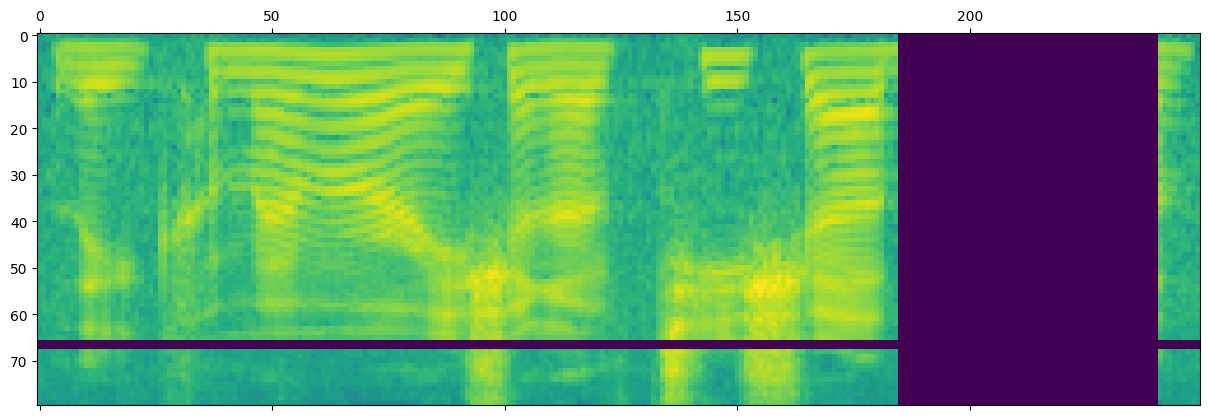

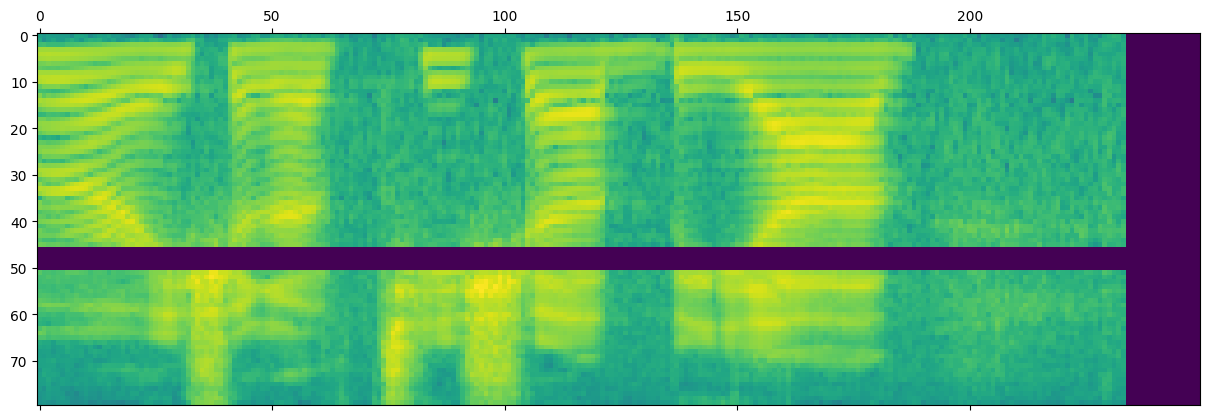

In [171]:
plt.matshow(sample_dev_batch["mel"].cpu()[i])
_ = plt.matshow(sample_dev_batch["mel_ref"].cpu()[i])
i += 1

In [7]:
from model import WhisperBackbone

/home/kd2939/dev/miniconda3/envs/emo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model = WhisperBackbone(
    pretrained_model_name_or_path="openai/whisper-small.en",
    max_duration=max_duration,
    pooling="mean",
).to(model_device)
contrastive_loss = losses.SelfSupervisedLoss(losses.NTXentLoss()).to(model_device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)
grad_scaler = torch.cuda.amp.GradScaler()

In [9]:
def train(
    model: nn.Module,
    dataloader: DALIGenericIterator,
    criterion,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
    grad_scaler: torch.cuda.amp.GradScaler,
    forward_pass_iters: int,
    grad_accum_iters: int,
    grad_norm: float,
    num_epochs: int,
    print_every: int,
    max_frames: int,
    feat_key: str,
    ref_key: str,
):
    model.train()
    device = model.device
    epoch_losses = []
    for epoch_ix in range(num_epochs):
        with tqdm(total=len(dataloader)) as pbar:
            tot_epoch_loss = torch.tensor(0.0).to(device)
            batch_idx = 0
            for batches in dataloader:
                for batch in batches:
                    # FORWARD PASS
                    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                        feats = batch[feat_key].to(device)
                        feats_ref = batch[ref_key].to(device)
                        attention_mask = num_frames_to_attention_mask(
                            num_frames=batch["num_frames"], max_frames=max_frames
                        ).to(device)
                        emb = model(feats, attention_mask)
                        emb_ref = model(feats_ref, attention_mask)
                        loss = criterion(emb, emb_ref)

                    # BACKWARD PASS
                    grad_scaler.scale(loss).backward()

                    # GRADIENT UPDATE
                    if (batch_idx + 1) % grad_accum_iters == 0:
                        if grad_norm is not None:
                            grad_scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(
                                model.parameters(), max_norm=grad_norm
                            )
                        grad_scaler.step(optimizer)
                        grad_scaler.update()
                        optimizer.zero_grad()

                    # PBAR UPDATE
                    with torch.no_grad():
                        tot_epoch_loss += loss
                    if ((batch_idx + 1) % print_every) == 0:
                        pbar.set_description(
                            f"train_loss: {tot_epoch_loss.cpu().item() / batch_idx:.2f}"
                        )
                    batch_idx += 1
                pbar.update(1)
            # FINAL PBAR UPDATE
            tot_epoch_loss = tot_epoch_loss.cpu().item() / batch_idx
            pbar.set_description(f"train_loss: {tot_epoch_loss:.2f}")
        epoch_losses.append(tot_epoch_loss)

        # LR SCHEDULER
        if lr_scheduler is not None:
            lr_scheduler.step()
    return epoch_losses

In [10]:
def validate(
    model: nn.Module,
    dataloader: DALIGenericIterator,
    criterion,
    forward_pass_iters: int,
    print_every: int,
    target_names: list[str],
    max_frames: int,
    feat_key: str,
    ref_key: str,
):
    model.eval()
    device = model.device
    batch_idx = 0
    with tqdm(total=len(dataloader)) as pbar:
        tot_epoch_loss = torch.tensor(0.0).cuda()
        for batches in dataloader:
            for batch in batches:
                # FORWARD PASS
                with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                    feats = batch[feat_key].to(device)
                    feats_ref = batch[ref_key].to(device)
                    attention_mask = num_frames_to_attention_mask(
                        num_frames=batch["num_frames"], max_frames=max_frames
                    ).to(device)
                    with torch.no_grad():
                        emb = model(feats, attention_mask)
                        emb_ref = model(feats_ref, attention_mask)
                        loss = criterion(emb, emb_ref)

                # PBAR UPDATE
                with torch.no_grad():
                    tot_epoch_loss += loss
                if ((batch_idx + 1) % print_every) == 0:
                    pbar.set_description(
                        f"dev_loss: {tot_epoch_loss.cpu().item() / batch_idx:.2f}"
                    )
                batch_idx += 1
            pbar.update(1)
        # FINAL PBAR UPDATE
        tot_epoch_loss = tot_epoch_loss.cpu().item() / batch_idx
        pbar.set_description(f"dev_loss: {tot_epoch_loss:.2f}")
    return tot_epoch_loss

In [11]:
def train_and_validate(
    model: nn.Module,
    train_dataloader: DALIGenericIterator,
    dev_dataloader: DALIGenericIterator,
    criterion,
    optimizer,
    lr_scheduler,
    grad_scaler: torch.cuda.amp.GradScaler,
    forward_pass_iters: int,
    grad_accum_iters: int,
    grad_norm: float,
    num_epochs: int,
    print_every: int,
    validate_every: int,
    target_names: list[str],
    max_frames: int,
    feat_key: str,
    ref_key: str,
):
    train_losses = []
    dev_losses = []
    for epoch_ix in range(num_epochs):
        train_losses.append(
            (
                epoch_ix + 1,
                train(
                    model=model,
                    dataloader=train_dataloader,
                    criterion=criterion,
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    grad_scaler=grad_scaler,
                    forward_pass_iters=forward_pass_iters,
                    grad_accum_iters=grad_accum_iters,
                    grad_norm=grad_norm,
                    num_epochs=1,
                    print_every=print_every,
                    max_frames=max_frames,
                    feat_key=feat_key,
                    ref_key=ref_key,
                )[0],
            )
        )
        if (epoch_ix + 1) % validate_every == 0:
            dev_losses.append(
                (
                    epoch_ix + 1,
                    validate(
                        model=model,
                        dataloader=dev_dataloader,
                        criterion=criterion,
                        forward_pass_iters=forward_pass_iters,
                        print_every=print_every,
                        target_names=target_names,
                        max_frames=max_frames,
                        feat_key=feat_key,
                        ref_key=ref_key,
                    ),
                )
            )
    return train_losses, dev_losses

In [ ]:
train_losses, dev_losses = train_and_validate(
    model=model,
    train_dataloader=train_dl,
    dev_dataloader=dev_dl,
    criterion=contrastive_loss,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    grad_scaler=grad_scaler,
    forward_pass_iters=1,
    grad_accum_iters=1,
    grad_norm=None,
    num_epochs=150,
    print_every=10,
    validate_every=1,
    target_names=EMOTIONS + ["other"],
    max_frames=max_frames,
    feat_key="mel",
    ref_key="mel_ref",
)

train_loss: 0.43:  78%|███████████████████████████████████████████████████████████████████████████████████████████████▋                           | 256/329 [02:29<00:42,  1.72it/s]

In [42]:
emo = []
emodim = []
embeddings = []
for batch in tqdm(dev_dl):
    feats = batch[0]["mel"]
    attention_mask = num_frames_to_attention_mask(
        batch[0]["num_frames"], max_frames=max_frames
    )
    with torch.inference_mode():
        emb = model(feats, attention_mask)
    embeddings.append(emb.cpu())
    emo.append(batch[0]["emo"])
    emodim.append(batch[0]["emodim"])
embeddings = torch.cat(embeddings).numpy()
emo = torch.cat(emo).numpy()
emodim = torch.cat(emodim).numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:26<00:00,  2.94it/s]


In [43]:
embeddings_tsne = TSNE(n_jobs=32).fit_transform(embeddings)

In [113]:
def plot_tsne(title, embeddings, targets, target_names):
    if len(target_names) <= 10:
        colors = cm.tab10(range(len(target_names)))
    else:
        raise ValueError()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title)
    for emotion_idx, emotion in enumerate(target_names):
        x = embeddings[targets == emotion_idx]
        ax.scatter(
            x[:, 0], x[:, 1], alpha=0.5, s=10, color=colors[emotion_idx], label=emotion
        )
    legend = ax.legend()
    for handle in legend.legend_handles:
        handle._sizes = [30]
    plt.close()
    return fig

In [118]:
def plot_tsne_emodim(title, embeddings, emodim):
    fig, ax = plt.subplots(figsize=(10, 30), nrows=3)
    valence = emodim[:, 0]
    arousal = emodim[:, 1]
    dominance = emodim[:, 2]
    ax[0].set_title(f"{title}: Valence")
    ax[0].scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        s=5,
        alpha=0.5,
        c=np.stack(
            (
                np.zeros(valence.shape[0]),
                valence ** (2),
                np.zeros(valence.shape[0]),
            ),
            axis=1,
        ),
    )
    ax[1].set_title(f"{title}: Arousal")
    ax[1].scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        s=5,
        alpha=0.5,
        c=np.stack(
            (
                arousal ** (2),
                np.zeros(valence.shape[0]),
                np.zeros(valence.shape[0]),
            ),
            axis=1,
        ),
    )
    ax[2].set_title(f"{title}: Dominance")
    ax[2].scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        s=5,
        alpha=0.5,
        c=np.stack(
            (
                np.zeros(valence.shape[0]),
                np.zeros(valence.shape[0]),
                dominance ** (2),
            ),
            axis=1,
        ),
    )
    plt.close()
    return fig

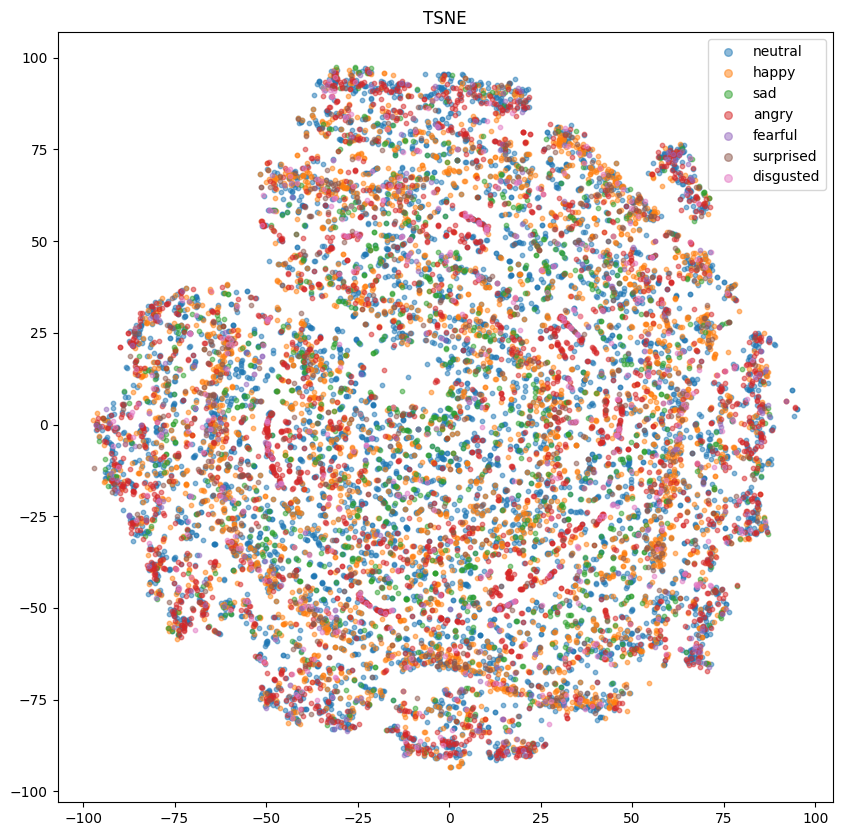

In [116]:
plot_tsne("TSNE", embeddings_tsne, targets=emo, target_names=EMOTIONS)

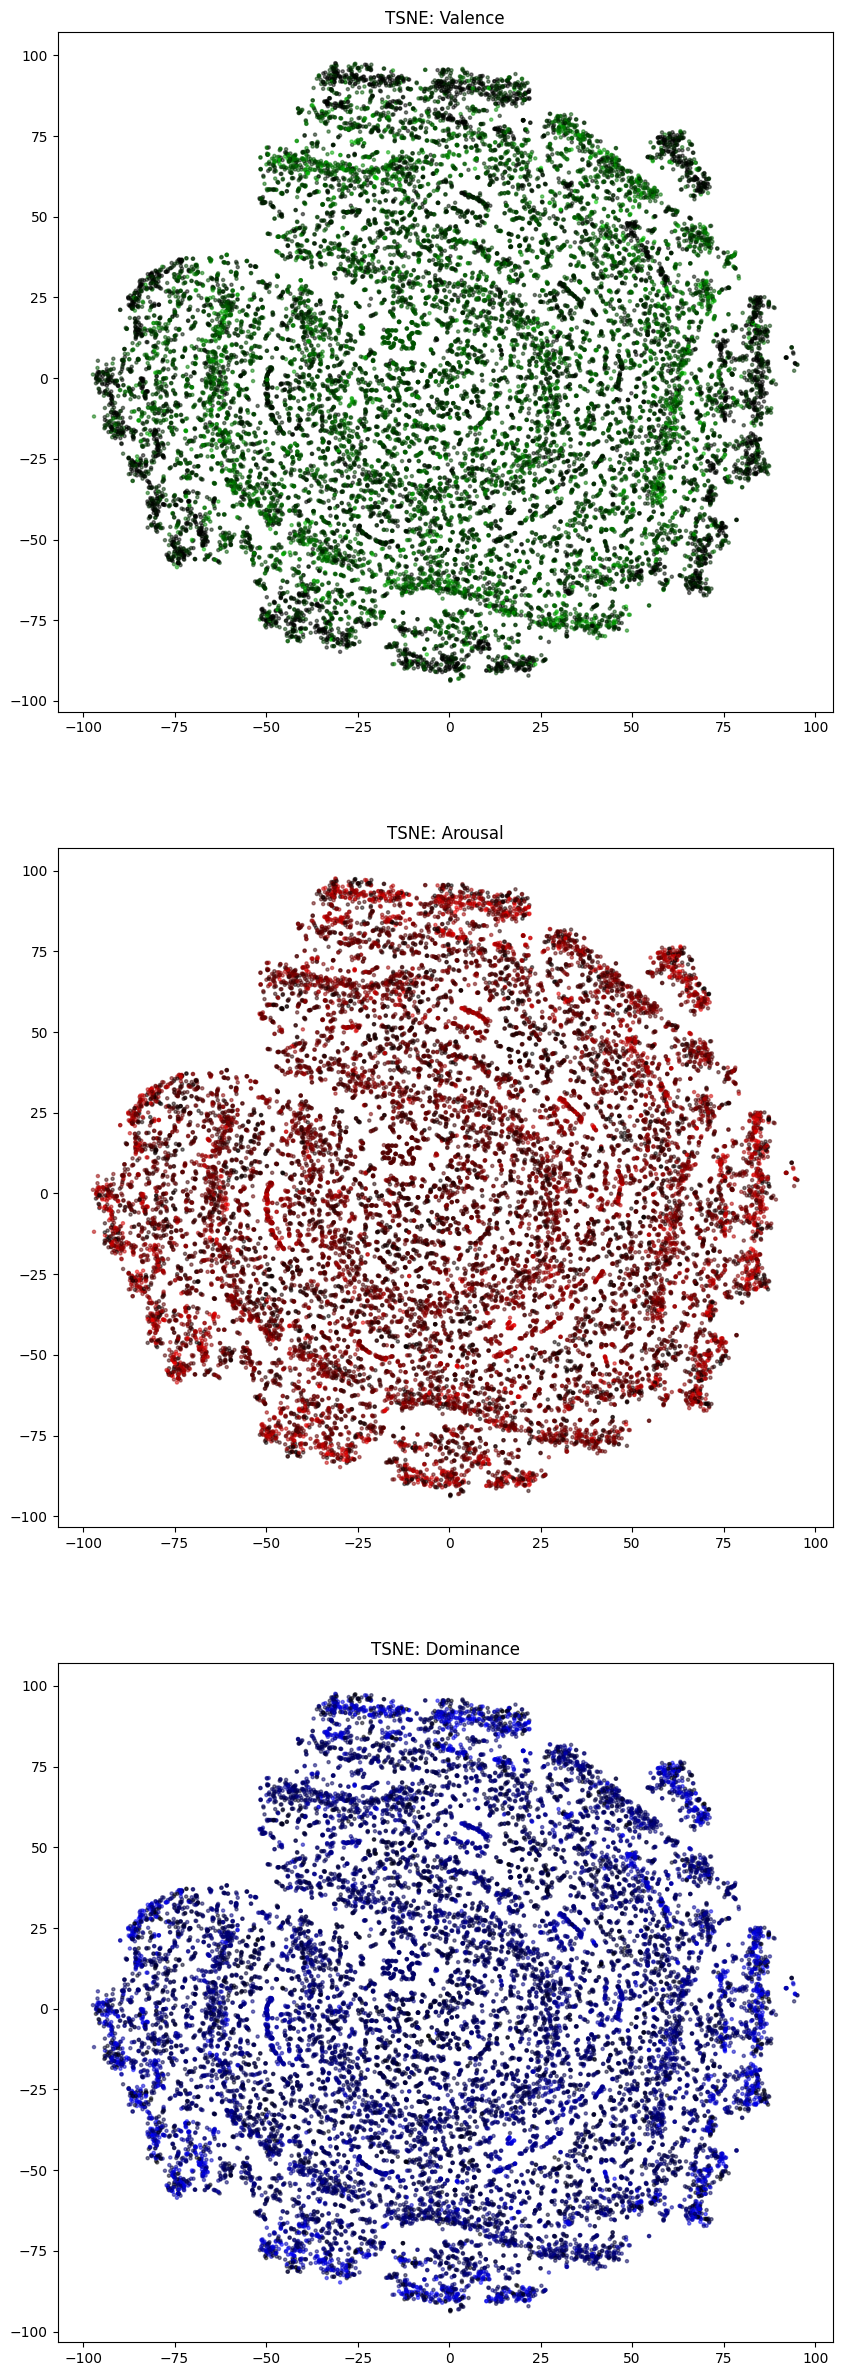

In [119]:
plot_tsne_emodim("TSNE", embeddings_tsne, emodim=emodim)

In [175]:
weights = model.cpu().state_dict()

In [186]:
torch.save(weights, f'./cpts/nb/contrastive_{get_timestamp()}.pt')